# Analysis: Logistic Regression for AfterMarket

Goal: Use logistic regression to create a model for the aftermarket feature.

In [1]:
import pandas as PD
import numpy as NP
import sklearn.preprocessing as PP
import sklearn.model_selection as MS
import sklearn.linear_model as LM
import statsmodels.stats as ST  # .outliers_influence.variance_inflation_factor
#from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

import matplotlib.pyplot as MP
import seaborn as SB
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Prepare Target & Features

In [3]:
FEATURE_FILE = '../data/merge_feature.csv'
full_df = PD.read_csv(FEATURE_FILE)
full_df.head()
full_df.info()

,set_no,name,price_store,price_used,aftermarket,popularity,category,year,volume,weight,total_parts,number_parts,number_colors,scolor_1st,scolor_2nd
0,858-1,Auto Engines,NaN,51.0,NaN,9.0,Technical,1980.0,NaN,NaN,242,46,5,Blue,Gray
1,1591-1,Danone Delivery Truck,NaN,28.0,NaN,NaN,Modern-Town,1980.0,NaN,NaN,40,19,4,White,Blue
2,1592-1,Town Square - Castle Scene,NaN,191.0,NaN,19.2,Modern-Town,1980.0,NaN,NaN,495,133,10,Black,Yellow
3,1651-2,Maersk Line Container Lorry,NaN,444.0,NaN,5.0,Modern-Town,1980.0,NaN,NaN,305,66,9,Blue,Gray
4,3634-1,Charlie Crow's Carry-All,NaN,13.0,NaN,3.0,Bigfig-Junior,1980.0,NaN,NaN,18,15,7,Yellow,Green


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5303 entries, 0 to 5302
Data columns (total 15 columns):
set_no           5303 non-null object
name             5303 non-null object
price_store      4178 non-null float64
price_used       4972 non-null float64
aftermarket      4035 non-null float64
popularity       4560 non-null float64
category         5303 non-null object
year             5303 non-null float64
volume           2143 non-null float64
weight           2154 non-null float64
total_parts      5303 non-null int64
number_parts     5303 non-null int64
number_colors    5303 non-null int64
scolor_1st       5294 non-null object
scolor_2nd       5301 non-null object
dtypes: float64(7), int64(3), object(5)
memory usage: 621.5+ KB


In [4]:
# drop volume and weight since they are sparse and colinear

full_df = full_df.drop(columns=['volume', 'weight'])

In [5]:
# filter out rows without aftermarket

full_df = full_df.loc[full_df['aftermarket'].isna()==False]
full_df.shape

(4035, 13)

In [6]:
# target series

target_sr = full_df['aftermarket'].apply(lambda f: 1 if f > 0 else 0)
target_sr.shape

(4035,)

In [7]:
# feature dataframe with one-hot encoding

columns_st = set(full_df.columns)
drop_st = set(['set_no', 'name', 'price_store', 'price_used', 'aftermarket', 'popularity'])
feature_st = columns_st.difference(drop_st)

feature_cat_df = full_df[list(feature_st)]

feature_df = PD.get_dummies(feature_cat_df, drop_first= True, 
               columns=['category', 'scolor_1st', 'scolor_2nd'])
feature_df.shape
feature_df.columns

(4035, 35)

Index(['number_parts', 'number_colors', 'year', 'total_parts',
       'category_Bigfig-Girls', 'category_Bigfig-Junior',
       'category_Constraction', 'category_Historical', 'category_Lego-Brand',
       'category_Licensed-Movie', 'category_Licensed-Other',
       'category_Licensed-StarWars', 'category_Modern-City',
       'category_Modern-Town', 'category_Space', 'category_Sports',
       'category_Technical', 'scolor_1st_Blue', 'scolor_1st_Brown',
       'scolor_1st_Gray', 'scolor_1st_Green', 'scolor_1st_Red',
       'scolor_1st_Tan', 'scolor_1st_Transparent', 'scolor_1st_White',
       'scolor_1st_Yellow', 'scolor_2nd_Blue', 'scolor_2nd_Brown',
       'scolor_2nd_Gray', 'scolor_2nd_Green', 'scolor_2nd_Red',
       'scolor_2nd_Tan', 'scolor_2nd_Transparent', 'scolor_2nd_White',
       'scolor_2nd_Yellow'],
      dtype='object')

## Split Test & Standardize

In [8]:
TEST_SPLIT = 0.2
SEED = 1

In [9]:
y_train, y_test, X_train, X_test = MS.train_test_split(target_sr, feature_df, 
                                                       stratify=feature_df['year'], 
                                                       test_size=TEST_SPLIT, random_state=SEED)

y_train.shape
y_test.shape 
X_train.shape
X_test.shape

(3228,)

(807,)

(3228, 35)

(807, 35)

In [10]:
# fit the scalers based on the training set
# must include all features, including one-hot encoded ones
# target variable does not need to be transformed

scaler = PP.StandardScaler()
scaler.fit(X_train)
scaler.mean_.shape

StandardScaler(copy=True, with_mean=True, with_std=True)

(35,)

In [11]:
# create standardized feature sets

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std.shape

(3228, 35)

In [12]:
InteractiveShell.ast_node_interactivity = 'last'

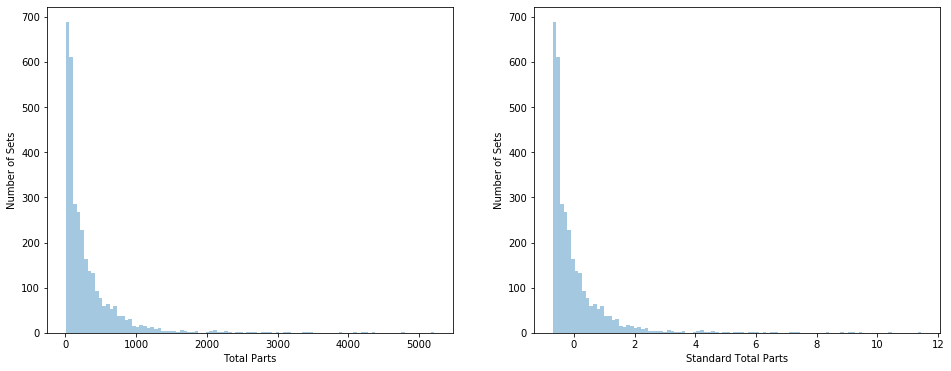

In [13]:
fig, axs = MP.subplots(1, 2, figsize=(16, 6))
parts_idx = X_train.columns.get_loc('total_parts')

SB.distplot(X_train['total_parts'], ax=axs[0], kde=False, bins=100)
axs[0].set(xlabel='Total Parts', ylabel='Number of Sets')

SB.distplot(X_train_std[:, parts_idx], ax=axs[1], kde=False, bins=100)
axs[1].set(xlabel='Standard Total Parts', ylabel='Number of Sets')

MP.show()

## Logistic Regression

In [14]:
# setup for several algorithms

algorithm_ls = []
alpha_ls = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

In [15]:
# lbfgs standalone 

logreg = LM.LogisticRegression(solver='lbfgs', penalty='none')
logreg.fit(X_train_std, y_train)
logreg.score(X_train_std, y_train)

0.7307930607187113

In [16]:
# use cross validation to evaluate algorithm

cv_results = MS.cross_validate(LM.LogisticRegression(solver='lbfgs', penalty='none'), X_train_std, y_train,
                               cv=5, return_train_score=True)
cv_results

{'fit_time': array([0.03215003, 0.02008581, 0.013726  , 0.01221108, 0.01139522]),
 'score_time': array([0.00114679, 0.00063634, 0.00064206, 0.00052404, 0.00096178]),
 'test_score': array([0.73570325, 0.74303406, 0.70542636, 0.75503876, 0.68992248]),
 'train_score': array([0.73111197, 0.73044152, 0.73674022, 0.72512582, 0.74216028])}

In [17]:
# compile algorithm results
# ok to use non-adjusted r-sq, use adjusted just for final test

new_dx = {
    'type': 'lbfgs',
    'lambda': NP.min(alpha_ls) - 0.5 *NP.min(alpha_ls), 
    'cvtrain_score': cv_results['train_score'].mean(),
    'cvtrain_error': cv_results['train_score'].std(),
    'cvtest_score': cv_results['test_score'].mean(),
    'cvtest_error': cv_results['test_score'].std(),
}
algorithm_ls.append(new_dx)
new_dx

{'type': 'lbfgs',
 'lambda': 0.0005,
 'cvtrain_score': 0.7331159632568649,
 'cvtrain_error': 0.00583002394100209,
 'cvtest_score': 0.7258249796752785,
 'cvtest_error': 0.02429926189893664}

In [18]:
# liblinear with L1 standalone 

logreg = LM.LogisticRegression(solver='liblinear', penalty='l1', C=.1)
logreg.fit(X_train_std, y_train)
logreg.score(X_train_std, y_train)

0.7317224287484511

In [19]:
# saga with L1 standalone 
# it's nearly identical to liblinear

logreg = LM.LogisticRegression(solver='saga', penalty='l1', C=.1)
logreg.fit(X_train_std, y_train)
logreg.score(X_train_std, y_train)

0.7304832713754646

In [20]:
# liblinear with L1

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='liblinear', penalty='l1', C=1/alpha)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'liblinear-L1',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [21]:
# saga with L1

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='saga', penalty='l1', C=1/alpha)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'saga-L1',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [22]:
# liblinear with L2

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='liblinear', penalty='l2', C=1/alpha)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'liblinear-L2',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [23]:
# newton with L2
# this is exactly the same as saga with L2

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='newton-cg', penalty='l2', C=1/alpha)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'newtoncg-L2',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [24]:
# sag with L2

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='sag', penalty='l2', C=1/alpha)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'sag-L2',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [25]:
# saga with L2

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='saga', penalty='l2', C=1/alpha)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'saga-L2',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

## Compare Algorithms

In [26]:
algorithm_df = PD.DataFrame(algorithm_ls)
algorithm_df.head()

,cvtest_error,cvtest_score,cvtrain_error,cvtrain_score,lambda,type
0,0.024299,0.725825,0.005830,0.733116,0.0005,lbfgs
1,0.024299,0.725825,0.005830,0.733116,0.0010,liblinear-L1
2,0.024299,0.725825,0.005830,0.733116,0.0100,liblinear-L1
3,0.024299,0.725825,0.005696,0.733116,0.1000,liblinear-L1
4,0.024198,0.725205,0.006061,0.733193,1.0000,liblinear-L1


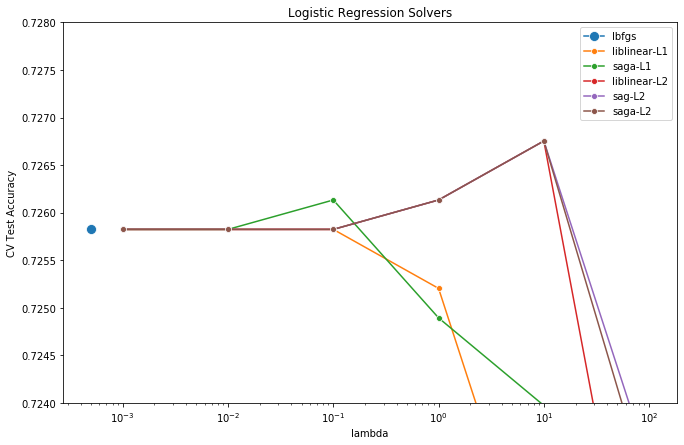

In [33]:
fig, axs = MP.subplots(1, 1, figsize=(11, 7), facecolor='white')


baseline_df = algorithm_df.loc[algorithm_df['type']=='lbfgs']
SB.lineplot(data=baseline_df, x='lambda', y='cvtest_score', marker='o', ax=axs, 
            label='lbfgs', markersize=10)

regular11_df = algorithm_df.loc[algorithm_df['type']=='liblinear-L1']
SB.lineplot(data=regular11_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='liblinear-L1')

regular12_df = algorithm_df.loc[algorithm_df['type']=='saga-L1']
SB.lineplot(data=regular12_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='saga-L1')

regular21_df = algorithm_df.loc[algorithm_df['type']=='liblinear-L2']
SB.lineplot(data=regular21_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='liblinear-L2')

regular23_df = algorithm_df.loc[algorithm_df['type']=='sag-L2']
SB.lineplot(data=regular23_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='sag-L2')

regular24_df = algorithm_df.loc[algorithm_df['type']=='saga-L2']
SB.lineplot(data=regular24_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='saga-L2')


axs.set(title='Logistic Regression Solvers', xlabel='lambda', ylabel='CV Test Accuracy', 
        xscale='log', ylim=(0.724, 0.728) )
axs.set_xticks(alpha_ls)

MP.show()